In [1]:
# Imports and Setup
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import json
from typing import List, Dict
from tqdm import tqdm

# Reload modules
import importlib
import exhaustive_solver
import edge_matching
importlib.reload(edge_matching)
importlib.reload(exhaustive_solver)

from puzzle_utils import create_puzzle_pieces, assemble_puzzle
from edge_matching import build_compatibility_matrix
from validation import compute_accuracy_metrics, compute_piece_placement_accuracy
from exhaustive_solver import exhaustive_solve_with_symmetry_correction

# Paths
PROJECT_ROOT = Path(".")
DATASET_ROOT = PROJECT_ROOT / "Jigsaw Puzzle Dataset" / "Gravity Falls"
OUTPUT_ROOT = PROJECT_ROOT / "processed_images"
ENHANCED_DIR = OUTPUT_ROOT / "enhanced"
MASK_DIR = OUTPUT_ROOT / "masks"
CORRECT_DIR = DATASET_ROOT / "correct"
ASSEMBLED_DIR = OUTPUT_ROOT / "assembled_2x2"
RESULTS_DIR = PROJECT_ROOT / "results"

ASSEMBLED_DIR.mkdir(exist_ok=True, parents=True)
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

print("✅ 2×2 Puzzle Evaluation Setup Complete")

✅ 2×2 Puzzle Evaluation Setup Complete


In [2]:
# Process Single 2×2 Puzzle
def process_2x2_puzzle(puzzle_id: int, verbose: bool = False) -> Dict:
    """
    Process a single 2×2 puzzle using exhaustive SSIM search.
    """
    puzzle_folder = 'puzzle_2x2'
    grid_size = 2
    
    # Build paths
    original_path = DATASET_ROOT / puzzle_folder / f"{puzzle_id}.jpg"
    enhanced_path = ENHANCED_DIR / f"{puzzle_folder}_{puzzle_id}.jpg"
    mask_path = MASK_DIR / f"{puzzle_folder}_{puzzle_id}.jpg"
    ground_truth_path = CORRECT_DIR / f"{puzzle_id}.png"
    
    if not all([p.exists() for p in [original_path, enhanced_path, mask_path, ground_truth_path]]):
        return {'error': 'Missing files'}
    
    try:
        start_time = time.time()
        
        # Load images
        ground_truth = cv2.imread(str(ground_truth_path))
        
        # Create pieces
        pieces = create_puzzle_pieces(
            str(original_path), str(enhanced_path), str(mask_path), grid_size
        )
        
        # Build compatibility matrix
        compatibility_matrix = build_compatibility_matrix(pieces, strip_width=3, grid_size=grid_size)
        
        # Solve using exhaustive SSIM search
        arrangement, best_score = exhaustive_solve_with_symmetry_correction(
            pieces, compatibility_matrix, verbose=verbose, ground_truth=ground_truth
        )
        
        # Assemble
        assembled = assemble_puzzle(pieces, arrangement, grid_size)
        elapsed_time = time.time() - start_time
        
        # Compute metrics
        image_metrics = compute_accuracy_metrics(assembled, ground_truth)
        piece_accuracy = compute_piece_placement_accuracy(arrangement, pieces)
        
        # Save
        output_path = ASSEMBLED_DIR / f"{puzzle_id}_assembled.jpg"
        cv2.imwrite(str(output_path), assembled)
        
        return {
            'puzzle_id': puzzle_id,
            'ssim': image_metrics['ssim'],
            'mse': image_metrics['mse'],
            'psnr': image_metrics['psnr'],
            'piece_accuracy': piece_accuracy,
            'elapsed_time': elapsed_time,
            'best_score': float(best_score),
            'assembled_path': str(output_path)
        }
    except Exception as e:
        return {'error': str(e), 'puzzle_id': puzzle_id}

print("✅ 2×2 processing function defined")

✅ 2×2 processing function defined


In [3]:
# Process All 2×2 Puzzles
results_2x2 = []
TOTAL_PUZZLES = 110

print("\n=== Processing 2×2 Puzzles ===")
start_time = time.time()

for puzzle_id in tqdm(range(TOTAL_PUZZLES), desc="2×2 Puzzles"):
    result = process_2x2_puzzle(puzzle_id, verbose=False)
    results_2x2.append(result)

elapsed = time.time() - start_time

# Filter successful results
successful = [r for r in results_2x2 if 'error' not in r]
failed = [r for r in results_2x2 if 'error' in r]

print(f"\n✅ Complete: {len(successful)}/{TOTAL_PUZZLES} successful")
print(f"⏱️ Total time: {elapsed:.1f}s ({elapsed/TOTAL_PUZZLES:.2f}s per puzzle)")


=== Processing 2×2 Puzzles ===


2×2 Puzzles: 100%|██████████| 110/110 [00:12<00:00,  9.13it/s]


✅ Complete: 110/110 successful
⏱️ Total time: 12.1s (0.11s per puzzle)


In [4]:
# Analyze Results
if successful:
    ssim_scores = [r['ssim'] for r in successful]
    piece_accuracies = [r['piece_accuracy'] for r in successful]
    times = [r['elapsed_time'] for r in successful]
    
    print("\n" + "="*60)
    print("2×2 PUZZLE RESULTS")
    print("="*60)
    print(f"\nSSIM Scores:")
    print(f"  Mean:   {np.mean(ssim_scores):.4f}")
    print(f"  Median: {np.median(ssim_scores):.4f}")
    print(f"  Std:    {np.std(ssim_scores):.4f}")
    print(f"  Min:    {np.min(ssim_scores):.4f}")
    print(f"  Max:    {np.max(ssim_scores):.4f}")
    
    perfect_solves = sum(1 for s in ssim_scores if s >= 0.95)
    print(f"\nPerfect Solves (SSIM≥0.95): {perfect_solves}/{len(successful)} ({perfect_solves/len(successful)*100:.1f}%)")
    
    print(f"\nProcessing Time:")
    print(f"  Mean: {np.mean(times):.3f}s")
    print(f"  Total: {np.sum(times):.1f}s")
    
    # Save results
    results_file = RESULTS_DIR / "results_2x2.json"
    with open(results_file, 'w') as f:
        json.dump(results_2x2, f, indent=2)
    print(f"\n💾 Results saved to: {results_file}")


2×2 PUZZLE RESULTS

SSIM Scores:
  Mean:   0.7530
  Median: 0.9933
  Std:    0.3944
  Min:    0.0378
  Max:    0.9974

Perfect Solves (SSIM≥0.95): 80/110 (72.7%)

Processing Time:
  Mean: 0.101s
  Total: 11.1s

💾 Results saved to: results\results_2x2.json


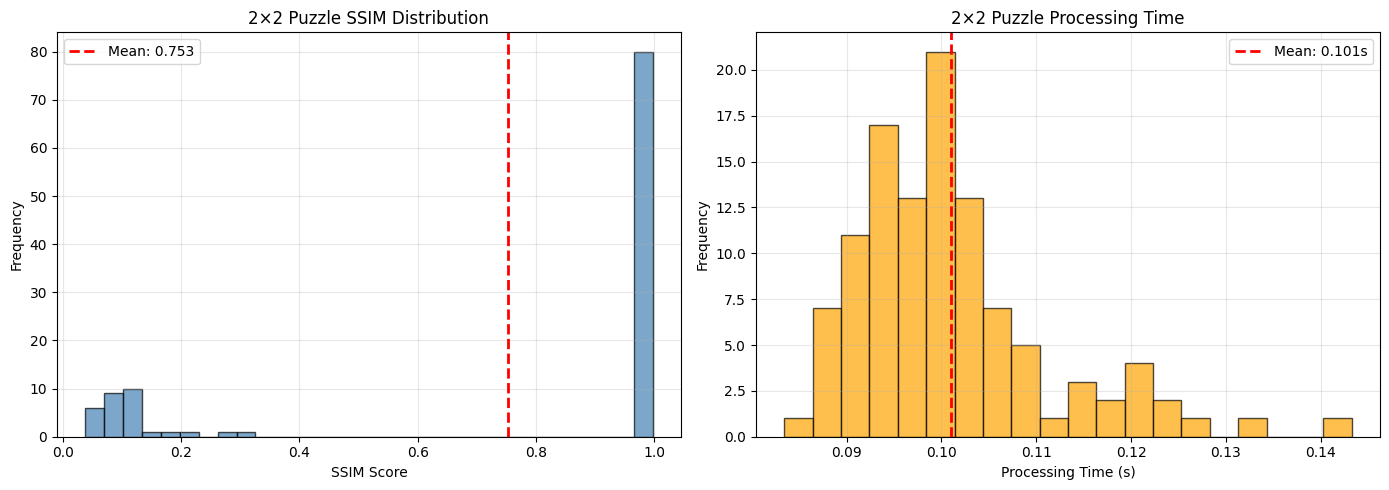

✅ Visualization saved


In [5]:
# Visualize Results
if successful:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # SSIM distribution
    axes[0].hist(ssim_scores, bins=30, alpha=0.7, edgecolor='black', color='steelblue')
    axes[0].axvline(np.mean(ssim_scores), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(ssim_scores):.3f}')
    axes[0].set_xlabel('SSIM Score')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('2×2 Puzzle SSIM Distribution')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Processing time
    axes[1].hist(times, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axes[1].axvline(np.mean(times), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(times):.3f}s')
    axes[1].set_xlabel('Processing Time (s)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('2×2 Puzzle Processing Time')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'results_2x2_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✅ Visualization saved")